# Olist project : customer segmentation  
## Recommendation on frequency updates of the segmentation 

The idea is to propose to the marketing team a maintenance contract. For that we need to know on which time bases the segmentation needs to be updated. We will base this study on the ARI (adjusted Rand index), which measure the degree of agreement between two data partitions. 
We will study the evolution of the segmentation based of the data from November 2017 to August 2018.

We are considering the pre-cleaned database (no missing values here):
- first we conduct a clustering with K-means at taking into account only orders before November 2017. This is our initial clustering. 
- secondly with update the database on a 15 days basis, taking into account the new orders made by costumers. We apply all the feature engineering, updating for example the mean order monetary value. We apply exactly the same process at for the initial clustering : outliers drop, log and box-cox transforms, PCA. 
- We compute the ARI between the initial clustering and the new clustering segmentation. 

The **maintenance time** is the time delta for the **ARI to drop under 0.7**. 


In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

import  pandas as pd 
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np 

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from scipy import stats
from geopy import distance


In [2]:
cData = pd.read_csv("cData.csv")
customersLocation = pd.read_csv("customersLocation.csv")
cData.columns

Index(['order_id', 'customer_id', 'order_status', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'date_purchase', 'order_approved_at_dt',
       'order_delivered_carrier_date_dt', 'order_delivered_customer_date_dt',
       'order_estimated_delivery_date_dt'],
      dtype='object')

In [3]:
customersLocation.columns

Index(['city', 'lat', 'lng'], dtype='object')

# Data preprocessing

In [4]:


def datetime_to_float(d, date0):

    # convert to Unix timestamp (in seconds)
    timestamp = (d - date0) / np.timedelta64(1, "s")

    # convert to float
    float_timestamp = float(timestamp)

    return float_timestamp


def generateNewVariables(rf, customersLocation, date0):
    # RFM
    orderTimePerClient = \
        rf.groupby("customer_unique_id")["date_purchase"].unique()
    for clientID in orderTimePerClient.index:
        lastOrderTime = np.max(orderTimePerClient[clientID])
        rf.loc[
            rf["customer_unique_id"] == clientID, "recency"
        ] = datetime_to_float(lastOrderTime, date0)

    numberOfItems = round(rf.groupby("customer_unique_id")["order_id"]
                          .count() / rf
                          .groupby("customer_unique_id")["order_id"]
                          .nunique())
    for clientID in numberOfItems.index:
        rf.loc[
            rf["customer_unique_id"] == clientID, "frequency"
        ] = numberOfItems[clientID]

    MontantPerClient = rf.groupby("customer_unique_id")["price"].sum()
    for clientID in MontantPerClient.index:
        rf.loc[

            rf["customer_unique_id"] == clientID, "montant"
        ] = MontantPerClient[clientID]
    # costumer_dist_from_capital

    sao_paulo_lat = (customersLocation
                     [customersLocation["city"] == 'sao paulo']
                     .lat.values[0])
    sao_paulo_lng = (customersLocation
                     [customersLocation["city"] == 'sao paulo']
                     .lng.values[0])

    dist = []
    for index, row in customersLocation.iterrows():
        distance_km = (distance.distance(
            (sao_paulo_lat, sao_paulo_lng),
            (row['lat'], row['lng']))
                    .km)
        dist.append(distance_km)
    customersLocation['DistFromCapital'] = dist

    for index, row in customersLocation.iterrows():
        rf.loc[rf['customer_city'] == row['city'],
               "costumer_dist_from_capital"] = \
                row["DistFromCapital"]

    customersLocation['DistFromCapital'].mean()
    rf.loc[rf["costumer_dist_from_capital"].isna(),
           "costumer_dist_from_capital"] = \
        customersLocation['DistFromCapital'].mean()
    return rf

In [5]:

def drop_stdOutliers_outliers(column, dataFrame, N=3):
    lower_range = np.mean(column) - N*np.std(column)
    upper_range = np.mean(column) + N*np.std(column)
    mask = (column < lower_range) | (column > upper_range)
    dataFrame.drop(column.loc[mask].index, inplace=True)


# Remove outliers
def drop_interquartile_outliers(column, dataFrame):
    Q3 = np.quantile(column, 0.75)
    Q1 = np.quantile(column, 0.25)
    IQR = Q3 - Q1
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    mask = (column < lower_range) | (column > upper_range)
    dataFrame.drop(column.loc[mask].index, inplace=True)

In [8]:
%pycodestyle_off
def preprocessing(rf, RFM, col):  # include PCA and feature engineering..

    # outliers
    drop_stdOutliers_outliers(rf["frequency"], rf)
    drop_stdOutliers_outliers(rf["montant"], rf)

    drop_interquartile_outliers(rf["costumer_dist_from_capital"],
                                rf)
    drop_interquartile_outliers(rf["review_score"], rf)
    drop_interquartile_outliers(rf["payment_installments"], rf)

    # feature engineering
    new_RFM = ["recency_bx", "frequency_lg", "montant_bx"]

    rf.loc[:, "frequency_lg"] = np.log(rf.loc[:, "frequency"])
    rf.loc[:, "recency_bx"], fitted_lambda = \
        stats.boxcox(rf.loc[:, "recency"])
    rf.loc[:, "montant_bx"], fitted_lambda = \
        stats.boxcox(rf.loc[:, "montant"])

    new_col = ["costumer_dist_from_capital_lg",
               "review_score", "payment_installments_bx"]

    rf.loc[rf['costumer_dist_from_capital'] == 0,
           'costumer_dist_from_capital'] = 1

    rf['costumer_dist_from_capital_lg'] = \
        np.log(rf['costumer_dist_from_capital'])

    clientsPlus = (
        rf.groupby("customer_unique_id")
        .first()[new_RFM + col + ['costumer_dist_from_capital_lg']]
        .reset_index()
    )

    paymentGroups = (
        clientsPlus
        .groupby("customer_unique_id")
        ["payment_installments"].mean())

    clientsPlus.loc[clientsPlus["customer_unique_id"] == paymentGroups.index,
                    "payment_installments"] = paymentGroups.values

    reviewGroups = rf.groupby("customer_unique_id")["review_score"].mean()
    clientsPlus.loc[clientsPlus["customer_unique_id"] == reviewGroups.index,
                    "review_score"] = reviewGroups.values

    #  Data must not be constant for boxcox transform :
    if len(clientsPlus['payment_installments'].unique()) != 1:
        clientsPlus["payment_installments_bx"], lmb = \
            stats.boxcox(clientsPlus["payment_installments"])
    else : # do not apply boxcox transform
        clientsPlus["payment_installments_bx"] = clientsPlus["payment_installments"]

    scaler = MinMaxScaler()  
    clientsPlus.loc[:, new_col+new_RFM] = scaler.fit_transform(clientsPlus.loc[:, new_col+new_RFM])

    clientsPlus.drop(columns=["payment_installments","costumer_dist_from_capital"],inplace=True)

    return clientsPlus, new_col, new_RFM
    
%pycodestyle_on

In [9]:
def clusteringPipeline(rf, date, date0, RFM, col):
    currentData = pd.DataFrame()
    currentData = rf[rf["date_purchase"] <= date]
    # print(currentData.shape)

    # ***************** FEATURE ENGINEERING ***************** #
    # ***************** Generate new variables ************** #
    generateNewVariables(currentData, customersLocation, date0)

    clientsPlus = pd.DataFrame()
    df_pca = pd.DataFrame()
    # ***************** apply prior transfomration  ************** #
    clientsPlus, new_col, new_RFM = preprocessing(currentData, RFM, col)

    # ***************** PCA  ************** #
    pca = PCA(n_components=6)
    X_trans = pca.fit_transform(clientsPlus[new_col + new_RFM])
    df_pca = pd.DataFrame(X_trans)

    # print(clientsPlus.shape)
    # print(df_pca.shape)

    kmeans = KMeans(
        n_clusters=4,
        init='k-means++',
        max_iter=300,
        random_state=42)

    kmeans.fit(df_pca)

    return kmeans, df_pca

## Main processing  :

In [13]:
cData["date_purchase"] = pd.to_datetime(cData["date_purchase"])

min = cData["date_purchase"].min()
print("min:", min)
max = cData["date_purchase"].max()
print("max:", max)

col = ['costumer_dist_from_capital', 'review_score',
       'payment_installments']

RFM = ["recency", "frequency", "montant"]

# ************ Initial clustering *************** #
date0 = min
dateOfInitialClustering = date0 + pd.Timedelta("300 days")  # init
print("Initial clustering model trained at ", dateOfInitialClustering)

initialKMeans, _ = clusteringPipeline(cData,
                                      dateOfInitialClustering,
                                      date0, RFM, col)

# ************ Clustering update *************** #
date = dateOfInitialClustering
aris = []
idx = 0
while date < max:

    kmeans, df_pca = clusteringPipeline(cData, date, date0, RFM, col)

    # ********************** ARI ****************** #

    kmeans.predict(df_pca)
    current_labels = kmeans.labels_
    inital_labels = initialKMeans.predict(df_pca)
    ari = adjusted_rand_score(inital_labels, current_labels)
    aris.append(ari)

    print("Date       : ", date)
    print("Data size  : ", df_pca.shape[0])
    print("ARI        : ", round(ari, 3), '\n')

    date = date + pd.Timedelta("15 days")

## Conclusion 

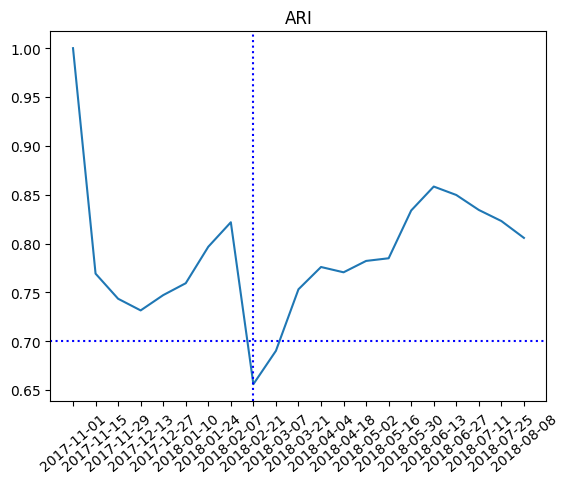

In [16]:
x_axis_dates = [dateOfInitialClustering
                + pd.Timedelta("14 days")*i for i in range(len(aris))]
x_axis_dates_str = [date.strftime("%Y-%m-%d") for date in x_axis_dates]
X_axis = [i for i in range(len(aris))]
%pycodestyle_off
for i in range(len(aris)):  # GET UPDATE INDEX
    if aris[i] < 0.7 :
        updateIndex = i 
        break
%pycodestyle_on
plt.plot(X_axis, aris)
plt.title("ARI")
plt.axhline(y = 0.7, color = 'b', linestyle = ':')
plt.axvline(x = updateIndex, color = 'b', linestyle = ':')
plt.xticks(X_axis, x_axis_dates_str,rotation = 40)
plt.show()

In [17]:
x_axis_dates[updateIndex] - dateOfInitialClustering

Timedelta('112 days 00:00:00')

The clustering needs to be review every 112 days, so about **every fours months**. 